# Results - Performance summary

## Prepare the data

### Function to obtain optimum F1 score

In [2]:
def getOptimalF1Score(y_true, y_score):

    from numpy import arange
    from numpy import argmax
    from sklearn.metrics import f1_score

    thresholds = arange(0, 1, 0.001)
    scores = [f1_score(y_true, (y_score >= t).astype('int')) for t in thresholds]
    ix = argmax(scores)
    return thresholds[ix], scores[ix]

### Read the required files

In [3]:
import os
import pandas as pd


mimicDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/data/data_matrix_mimic.csv')
eicuDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/data/data_matrix_eicu.csv')
eicuUsingMimicDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/prediction/eicu_using_mimic_model_wb_30_wa_30.csv')
mimicUsingEicuDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/prediction/mimic_using_eicu_model_wb_30_wa_30.csv')

mimicDataDf.shape, eicuDataDf.shape, mimicUsingEicuDataDf.shape, eicuUsingMimicDataDf.shape

((31646, 105), (56237, 106), (6277, 3), (11145, 3))

### Calculate performance metrics

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


mimicMergedDf = mimicUsingEicuDataDf.merge(
    mimicDataDf[['person_id', 'visit_occurrence_id', 'death_0_30_adm']].drop_duplicates(),
    how='inner',
    on=['person_id', 'visit_occurrence_id']
)

eicuMergedDf = eicuUsingMimicDataDf.merge(
    eicuDataDf[['person_id', 'visit_occurrence_id', 'death_0_30_adm']].drop_duplicates(),
    how='inner',
    on=['person_id', 'visit_occurrence_id']
)

for mergedDf in [mimicMergedDf, eicuMergedDf]:
    cutoffThreshold, optimalF1Score = getOptimalF1Score(y_true=mergedDf['death_0_30_adm'], y_score=mergedDf.preds)
    cutoff = cutoffThreshold

    accuracy = accuracy_score(y_true=mergedDf['death_0_30_adm'], y_pred=mergedDf.preds.apply(lambda x: 1 if (x > 0.5) else 0))
    balanced_accuracy = balanced_accuracy_score(y_true=mergedDf['death_0_30_adm'], y_pred=mergedDf.preds.apply(lambda x: 1 if (x > 0.5) else 0))
    average_precision = average_precision_score(y_true=mergedDf['death_0_30_adm'], y_score=mergedDf.preds)
    f1 = f1_score(y_true=mergedDf['death_0_30_adm'], y_pred=mergedDf.preds.apply(lambda x: 1 if (x > 0.5) else 0))
    roc_auc = roc_auc_score(y_true=mergedDf['death_0_30_adm'], y_score=mergedDf.preds)

    print('accuracy: ', accuracy, 'balanced_accuracy: ', balanced_accuracy, 'average_precision: ', average_precision, 'f1: ', f1, 'roc_auc: ', roc_auc)

accuracy:  0.7694758642663693 balanced_accuracy:  0.5857515994746184 average_precision:  0.33107321053114536 f1:  0.3222482435597189 roc_auc:  0.6496354376823434
accuracy:  0.8756393001345895 balanced_accuracy:  0.5291717636752984 average_precision:  0.21611282609425572 f1:  0.12720403022670024 roc_auc:  0.6619214112408318


## Plot AUROC

### Create a dataframe for AUROC

In [25]:
import numpy as np


plotDf = pd.DataFrame(np.zeros([2, 2])*np.nan, columns=['MIMIC', 'eICU'], index=['MIMIC', 'eICU'])
plotDf.loc['MIMIC', 'MIMIC'] = 0.809
plotDf.loc['eICU', 'eICU'] = 0.845
plotDf.loc['MIMIC', 'eICU'] = 0.649
plotDf.loc['eICU', 'MIMIC'] = 0.662
plotDf


,MIMIC,eICU
MIMIC,0.809,0.649
eICU,0.662,0.845


### Plot heatmap

[Text(0.5, 23.52222222222222, 'Training Dataset'),
 Text(50.722222222222214, 0.5, 'Validation Dataset')]

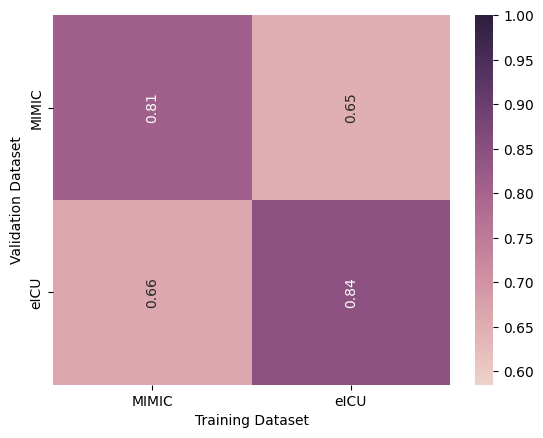

In [27]:
import seaborn as sns


s = sns.heatmap(
    plotDf,
    annot=True,
    fmt=".2f",
    vmin=1,
    vmax=0.65,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot_kws={'rotation': 90},
)
s.set(xlabel='Training Dataset', ylabel='Validation Dataset')


## Plot Accuracy

### Create a dataframe for Accuracy

In [28]:
import numpy as np


plotDf = pd.DataFrame(np.zeros([2, 2])*np.nan, columns=['MIMIC', 'eICU'], index=['MIMIC', 'eICU'])
plotDf.loc['MIMIC', 'MIMIC'] = 0.844
plotDf.loc['eICU', 'eICU'] = 0.896
plotDf.loc['MIMIC', 'eICU'] = 0.769
plotDf.loc['eICU', 'MIMIC'] = 0.875
plotDf

,MIMIC,eICU
MIMIC,0.844,0.769
eICU,0.875,0.896


### Plot heatmap

[Text(0.5, 23.52222222222222, 'Training Dataset'),
 Text(50.722222222222214, 0.5, 'Validation Dataset')]

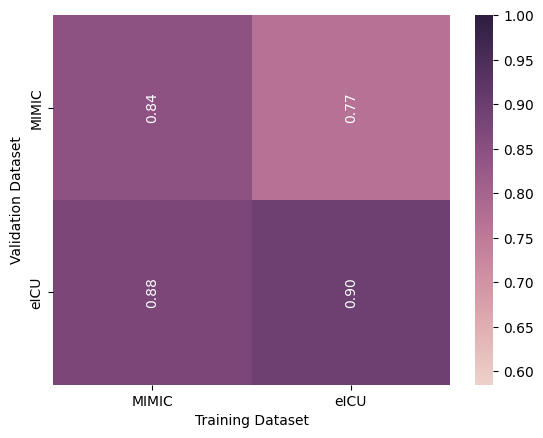

In [29]:
import seaborn as sns


s = sns.heatmap(
    plotDf,
    annot=True,
    fmt=".2f",
    vmin=1,
    vmax=0.65,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot_kws={'rotation': 90},
)
s.set(xlabel='Training Dataset', ylabel='Validation Dataset')

## Feature Importance Analysis

In [63]:
import os
import pandas as pd


eicuImportanceDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/experiments/inter_source_validation/feature_importance/eicu_wb_30_wa_30/ensemble_feature_importance.csv''')
mimicImportanceDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/experiments/inter_source_validation/feature_importance/mimic_wb_30_wa_30/ensemble_feature_importance.csv''')

eicuImportanceDf.shape, mimicImportanceDf.shape

((100, 2), (100, 2))

In [48]:
import pandas as pd


eicuImportanceDf['Data'] = 'EICU'
mimicImportanceDf['Data'] = 'MIMIC'
plotDf = pd.concat([eicuImportanceDf, mimicImportanceDf])
plotDf

,Feature_Name,Feature_Importance,Data
0,labs_MCHC_avg,0.007322,EICU
1,labs_MCHC_first,0.006037,EICU
2,labs_MCHC_last,0.006052,EICU
3,labs_MCHC_max,0.005846,EICU
4,labs_MCHC_min,0.007051,EICU
...,...,...,...
95,vitals_systemic_systolic_avg,0.021186,MIMIC
96,vitals_systemic_systolic_first,0.018205,MIMIC
97,vitals_systemic_systolic_last,0.082844,MIMIC
98,vitals_systemic_systolic_max,0.040846,MIMIC


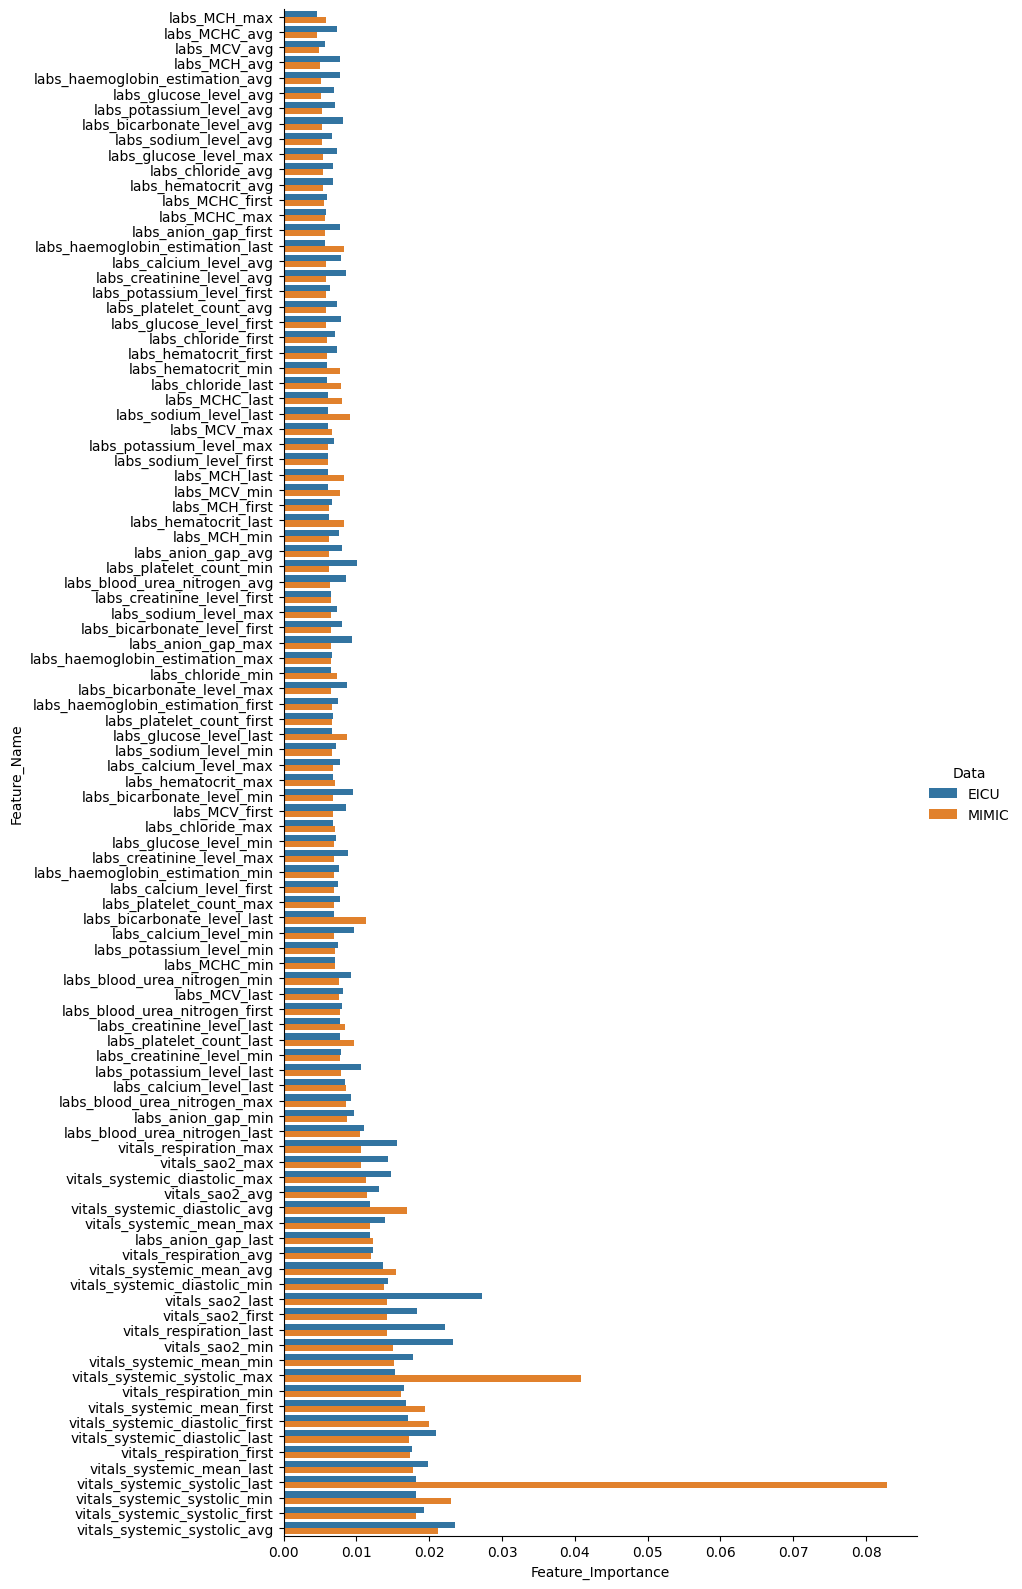

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(x="Feature_Importance", y="Feature_Name",
                hue="Data",
                data=plotDf.sort_values(by='Feature_Importance'), kind="bar", orient='h',
                height=16, aspect=0.6)


In [65]:
plotDf = eicuImportanceDf.add_prefix('MIMIC_').merge(
            mimicImportanceDf.add_prefix('EICU_'),
            how='inner',
            left_on='MIMIC_Feature_Name',
            right_on='EICU_Feature_Name'
        ).drop(
            columns=['EICU_Feature_Name']
        ).rename(columns={'MIMIC_Feature_Name': 'Feature_Name'})
plotDf['diff'] = plotDf.MIMIC_Feature_Importance - plotDf.EICU_Feature_Importance
plotDf

,Feature_Name,MIMIC_Feature_Importance,EICU_Feature_Importance,diff
0,labs_MCHC_avg,0.007322,0.004539,0.002783
1,labs_MCHC_first,0.006037,0.005573,0.000464
2,labs_MCHC_last,0.006052,0.008011,-0.001959
3,labs_MCHC_max,0.005846,0.005749,0.000097
4,labs_MCHC_min,0.007051,0.007117,-0.000066
...,...,...,...,...
95,vitals_systemic_systolic_avg,0.023509,0.021186,0.002323
96,vitals_systemic_systolic_first,0.019249,0.018205,0.001044
97,vitals_systemic_systolic_last,0.018172,0.082844,-0.064672
98,vitals_systemic_systolic_max,0.015259,0.040846,-0.025586


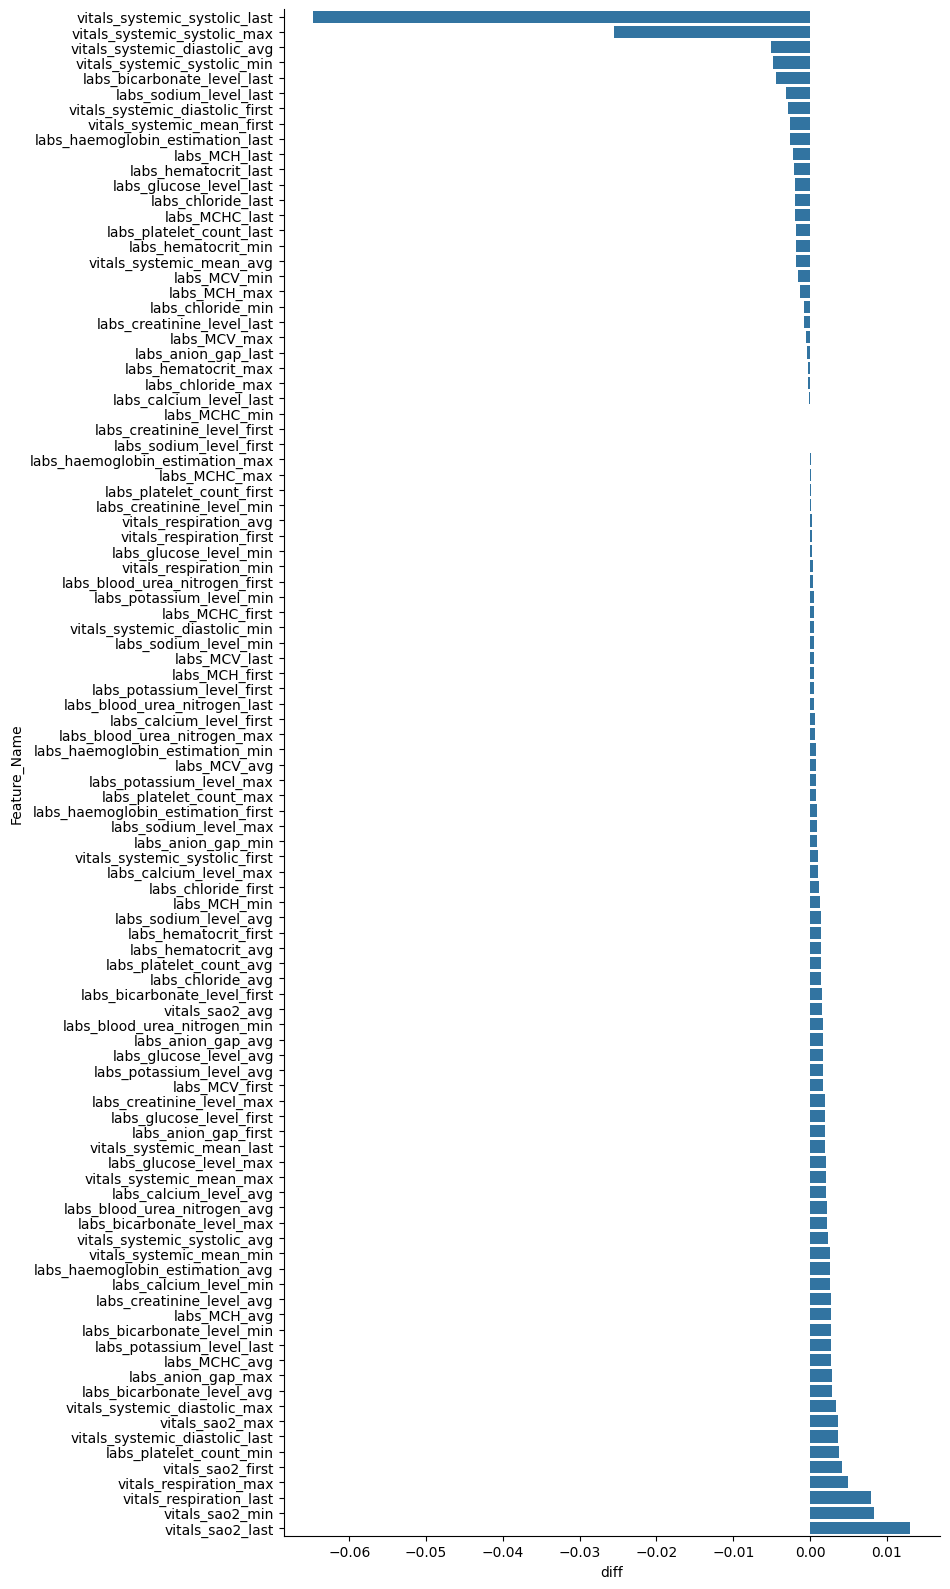

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(x="diff", y="Feature_Name",
                data=plotDf.sort_values(by='diff'), kind="bar", orient='h',
                height=16, aspect=0.6)


In [70]:
plotDf = eicuImportanceDf.add_prefix('MIMIC_').merge(
            mimicImportanceDf.add_prefix('EICU_'),
            how='inner',
            left_on='MIMIC_Feature_Name',
            right_on='EICU_Feature_Name'
        ).drop(
            columns=['EICU_Feature_Name']
        ).rename(columns={'MIMIC_Feature_Name': 'Feature_Name'})
plotDf['MIMIC_Feature_Rank'] = plotDf['MIMIC_Feature_Importance'].rank()
plotDf['EICU_Feature_Rank'] = plotDf['EICU_Feature_Importance'].rank()
plotDf['diff'] = plotDf.MIMIC_Feature_Rank - plotDf.EICU_Feature_Rank
plotDf

,Feature_Name,MIMIC_Feature_Importance,EICU_Feature_Importance,MIMIC_Feature_Rank,EICU_Feature_Rank,diff
0,labs_MCHC_avg,0.007322,0.004539,36.0,1.0,35.0
1,labs_MCHC_first,0.006037,0.005573,7.0,12.0,-5.0
2,labs_MCHC_last,0.006052,0.008011,8.0,62.0,-54.0
3,labs_MCHC_max,0.005846,0.005749,4.0,13.0,-9.0
4,labs_MCHC_min,0.007051,0.007117,31.0,52.0,-21.0
...,...,...,...,...,...,...
95,vitals_systemic_systolic_avg,0.023509,0.021186,99.0,97.0,2.0
96,vitals_systemic_systolic_first,0.019249,0.018205,94.0,94.0,0.0
97,vitals_systemic_systolic_last,0.018172,0.082844,91.0,100.0,-9.0
98,vitals_systemic_systolic_max,0.015259,0.040846,84.0,99.0,-15.0


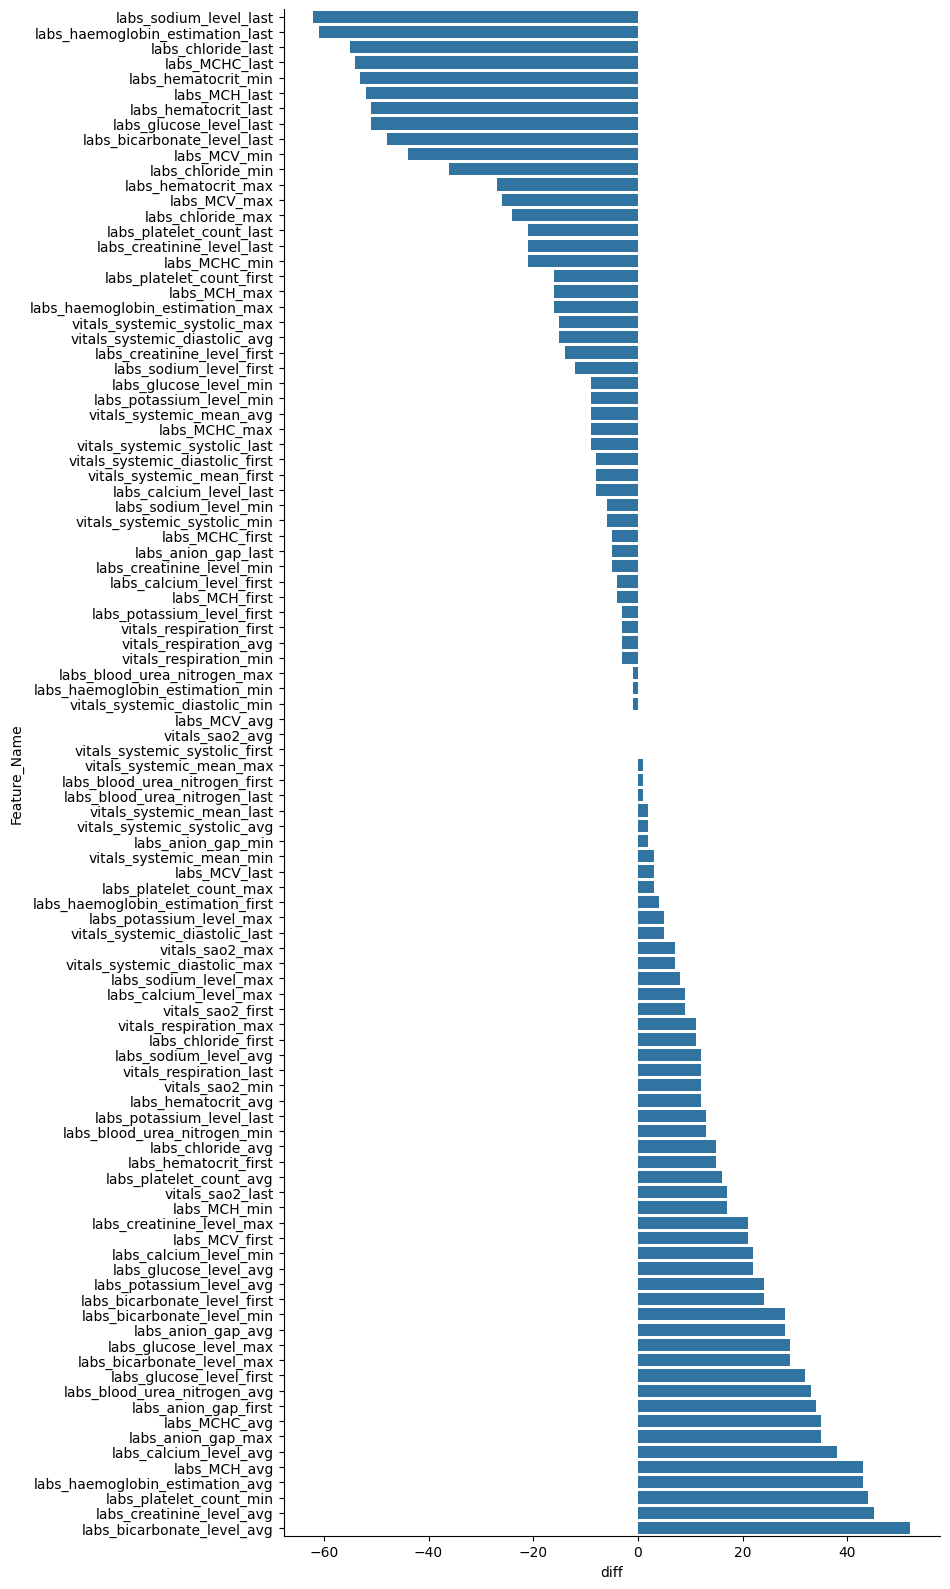

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(x="diff", y="Feature_Name",
                data=plotDf.sort_values(by='diff'), kind="bar", orient='h',
                height=16, aspect=0.6)
